# LING 83800 Homework 2

In this homework, we will be using finite state machines to restore vowels to vowelless text using pynini. While this is not very useful for English, but it is for languages like Hebrew and Arabic where vowels are regularly omitted.

## Instructions

1. Clone this repository to your local machine
1. Make sure pynini is installed (`conda install -c conda-forge pynini`)
1. Complete the cells with instructions
1. Submit your final notebook via blackboard.

## Tips

You will find the [pynini documentation](http://www.openfst.org/twiki/bin/view/GRM/PyniniDocs) useful in completing this assignment.

Particularly useful pynini functions for this assignment are:
   * `pynini.cdrewrite()`
   * `pynini.concat()`
   * `pynini.compose()`
   * `pynini.invert()`
   * `pynini.shortestpath()`
   * `pynini.union()`
   * `pynini.Fst.closure()`
   * `pynini.Fst.num_states()`
   * `pynini.Fst.optimize()`
   * `pynini.Fst.project()`
   * `pynini.Fst.string()`

In [1]:
import pynini
import string

# 1. Finite state acceptor

In this first problem, we will make a finite state acceptor for all valid English words.

## Example: Toy vocabulary

Here is an FSA that accepts the three words "at", "an", and "age" that we will use as an example. Note the use of the `*` operator on the list to expand it into the list of arguments to `pynini.union()`.

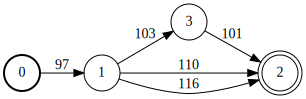

In [2]:
vocab = ["at", "an", "age"]
at_an_age_only = pynini.union(*vocab).optimize()
at_an_age_only

Notice that it accepts any of those words, but nothing else

In [3]:
pynini.compose("at", at_an_age_only).string()

'at'

In [4]:
for word in ['at', 'an', 'age', 'and', 'aardvark']:
    try:
        print(pynini.compose(word, at_an_age_only).string())
    except pynini.FstOpError:
        print("Failed:", word)

at
an
age
Failed: and
Failed: aardvark


## 1.1. Use concatenation and closure to create an FSA that accepts sequences of the words "at", "an", and "age" (in any order) separated by spaces

For example, it should accept "at an age", but it should reject "at and age" and "atanage"

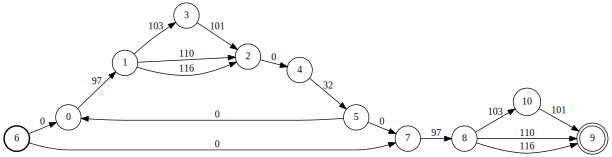

In [5]:
# TODO: your code here, assigning the FSA to at_an_age

at_an_age = pynini.concat(at_an_age_only, " ").closure().concat(at_an_age_only)
at_an_age

Test your code:

In [6]:
assert pynini.compose("at an age", at_an_age).string() == "at an age"
print("Correctly accepted", "at an age")

for bad_sentence in ['at and age', 'atanage']:
    try:
        print(pynini.compose(bad_sentence, at_an_age_only).string())
    except pynini.FstOpError:
        print("Correctly rejected", bad_sentence)

Correctly accepted at an age
Correctly rejected at and age
Correctly rejected atanage


## 1.2. Write a function to convert an FSA that accepts individual words into an FSA that accepts space-separated sequences of those words

In [7]:
# TODO: your code here, call the function space_separated_closure

def space_separated_closure(fst: pynini.Fst) -> pynini.Fst:
    return pynini.concat(fst, " ").closure().concat(fst)

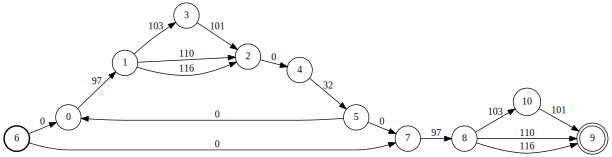

In [8]:
space_separated_closure(at_an_age_only)

Test that it gives you the same FSA

In [9]:
assert pynini.equivalent(at_an_age.optimize(), space_separated_closure(at_an_age_only).optimize())

## 1.3 Create an FSA that accepts individual English words

I have given you a file containing "all" of the valid English words that we are considering here called "english_all.txt". Each line contains one word.

In [10]:
# TODO: your code here, put the FSA in the variable english
words = open("english_all.txt").read().split("\n")
english = pynini.union(*words).optimize()

Test that it works on valid words

In [11]:
for word in ["pacheco", "extravagant", "hevey", "anchorage", "wearers", "corroded", "hallen", "hegenna", "nostrand", "silvershoe"]:
    pynini.compose(word, english).string()
    print("Succeeded for", word)

Succeeded for pacheco
Succeeded for extravagant
Succeeded for hevey
Succeeded for anchorage
Succeeded for wearers
Succeeded for corroded
Succeeded for hallen
Succeeded for hegenna
Succeeded for nostrand
Succeeded for silvershoe


Test that it doesn't work on invalid words

In [12]:
for bad_word in ["sooper", "seekrit", "deeeecoder", "ringgg", "more than one word"]:
    try:
        print(pynini.compose(bad_word, english).string())
    except pynini.FstOpError:
        print("Correctly rejected", bad_word)

Correctly rejected sooper
Correctly rejected seekrit
Correctly rejected deeeecoder
Correctly rejected ringgg
Correctly rejected more than one word


## 1.4. Create the space-separated closure of english words

In [13]:
# TODO: your code here. Call the FSA english_sentences
english_sentences = space_separated_closure(english)

Test that it works on valid sentences

In [14]:
for sentence in ["more than one word", "pacheco extravagant", "hevey anchorage wearers", "corroded hallen hegenna nostrand", "silvershoe"]:
    pynini.compose(sentence, english_sentences).string()
    print("Succeeded for", sentence)

Succeeded for more than one word
Succeeded for pacheco extravagant
Succeeded for hevey anchorage wearers
Succeeded for corroded hallen hegenna nostrand
Succeeded for silvershoe


Test that it doesn't work on invalid sentences

In [15]:
for bad_sentence in ["sooper seekrit", "deeeecoder", "ringgg more than one word"]:
    try:
        print(pynini.compose(bad_sentence, english_sentences).string())
    except pynini.FstOpError:
        print("Correctly rejected", bad_sentence)

Correctly rejected sooper seekrit
Correctly rejected deeeecoder
Correctly rejected ringgg more than one word


# 2. A transducer to remove vowels

In this section, we will create an FST to remove vowels from strings.

In [16]:
alphabet = list(string.ascii_lowercase) + [" ", "-"]

## 2.1 Make the transducer to remove vowels

You will need to make a `pynini.transducer()` from vowels to the empty string and then use `pynini.cdrewrite()` to make a context-dependent rewrite transducer, but don't give it any context (use the empty string for the left and right context). You will also need to define `sigma_star` the closure of the `alphabet` just defined.

In [17]:
# TODO: your code here. Put the vowel remover transformer in the variable_vowel_remover
sigma_star = pynini.union(*alphabet).closure().optimize()
rule = pynini.transducer(pynini.union("a", "e", "i", "o", "u"), "")
vowel_remover = pynini.cdrewrite(rule, "", "", sigma_star)

Test that it works

In [18]:
assert pynini.compose("dendrochronology uncharacteristic shortsightedness", vowel_remover).string() == 'dndrchrnlgy nchrctrstc shrtsghtdnss'
print('Worked')

Worked


Here is a function to do that for you

In [19]:
def remove_vowels(sentence, vowel_remover):
    return pynini.compose(sentence, vowel_remover).string()

## 2.2 Make an FST to add vowels back to strings

Use the function `pynini.invert()` to exchange the input and output strings of the FST relation.

In [20]:
# TODO: your code here, call your vowel-adding FST vowel_adder

vowel_adder = pynini.invert(vowel_remover)

## 2.3 Write a function to apply the vowel_adder to a string

1. Compose the string with the vowel_adder
1. Project the results onto the output symbols
1. Find the shortest path through this combined FSA
1. Convert to a string

In [21]:
# TODO: your code here. Call your decoding function add_vowels()

def add_vowels(sentence, vowel_adder):
    return pynini.shortestpath(
        pynini.compose(sentence, vowel_adder).project(True)).string()

Test it

In [22]:
add_vowels('dndrchrnlgy nchrctrstc shrtsghtdnss', vowel_adder)

'dndrchrnlgy nchrctrstc shrtsghtdnss'

## 2.4 Discuss why it doesn't work

Write in the markdown box below:
1. What is going on
1. Why it is going on

It didn't work because this function shows the shortest path that the FST vowel_adder can take, and the shortest (lowest weight) path is not to add anything.

# 3. Use your english sentence FSA to require your vowel adder to emit valid english sentences

## 3.1. Compose your vowel adder FST with your english sentence FSA

In [23]:
# TODO: your code here. Call the resulting FST vowel_adder_valid

vowel_adder_valid = vowel_adder @ english_sentences

Test it

In [24]:
assert add_vowels('dndrchrnlgy nchrctrstc shrtsghtdnss', vowel_adder_valid) == 'dendrochronology uncharacteristic shortsightedness'
print("Success!")

Success!


In [25]:
sentence = "roark foot rerun leading overly cross birds"
reconstruction = add_vowels(remove_vowels(sentence, vowel_remover), vowel_adder_valid)
if reconstruction != sentence:
    print("Not reconstructed:", sentence, "->", reconstruction)

Not reconstructed: roark foot rerun leading overly cross birds -> rurik foti rerun loading verley cruises broadus


## 3.2. Discuss why it doesn't work

Write in the markdown box below:
1. What is going on
1. Why it is going on

It doesn't work because the FST vowel_adder_valid is non-deterministic, which means there are several paths possible for adding the vowels. Thus, the function add_vowels only shows the shortest path output, which is not necessarily the original one.

## 3.3. Try adding a (character) language model

I have created a 5-gram character language model in the file `english_all.lm5`. I used the following OpenGRM commands to do so:

```bash
farcompilestrings --far_type=compact_string --token_type=byte english_all.txt english_all.far
ngramcount --order=5 --require_symbols=false english_all.far english_all.cnts5
ngrammake --method=witten_bell english_all.cnts5 english_all.lm5
```

Load the language model using `pynini.Fst.read()` and compose your `vowel_adder_valid` FST with it to make a new FST that weights the translations with this model

In [26]:
# TODO: your code goes here, call your model vowel_adder_lm5
lm = space_separated_closure(pynini.Fst.read("english_all.lm5"))
vowel_adder_lm5 = vowel_adder_valid @ lm

Test it

In [27]:
sentence = "roark foot rerun leading overly cross birds"
reconstruction = add_vowels(remove_vowels(sentence, vowel_remover), vowel_adder_lm5)
if reconstruction == sentence:
    print("Success")

Success


## 3.4. Optional: Make it better

Use the below function to evaluate the word reconstruction accuracy of your model on the sentences in the file `strings.txt`. The `vowel_adder_valid` model gets 26% of the words right. The `vowel_adder_lm5` model gets 35% of the words right. Can you make it better?

In [28]:
def evaluate_words(vowel_adder):
    right, total = 0, 1e-9
    with open("strings.txt", "r") as strings:
        for string in strings:
            string = string.strip()
            words = string.split(" ")
            total += len(words)
            try:
                no_vowels = remove_vowels(string.strip(), vowel_remover)
                re_voweled = add_vowels(no_vowels, vowel_adder)
                re_worded = re_voweled.split(" ")
                for pred, gt in zip(re_worded, words):
                    if pred == gt:
                        right += 1
            except pynini.FstOpError:
                # print("Failed:", string)
                pass
    return right / total

In [29]:
evaluate_words(vowel_adder_valid)

0.26198830409326085

In [30]:
evaluate_words(vowel_adder_lm5)

0.3497076023387723

In [ ]:
l_model = space_separated_closure(pynini.Fst.read("english_all.lm5"))
l_model.optimize()
lm5 = vowel_adder_valid @ l_model